In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re

from pytesseract import Output

In [3]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
def plot_img(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image)
def plot_big(image):
    plt.figure(figsize=(64,40))
    return plt.imshow(image)
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

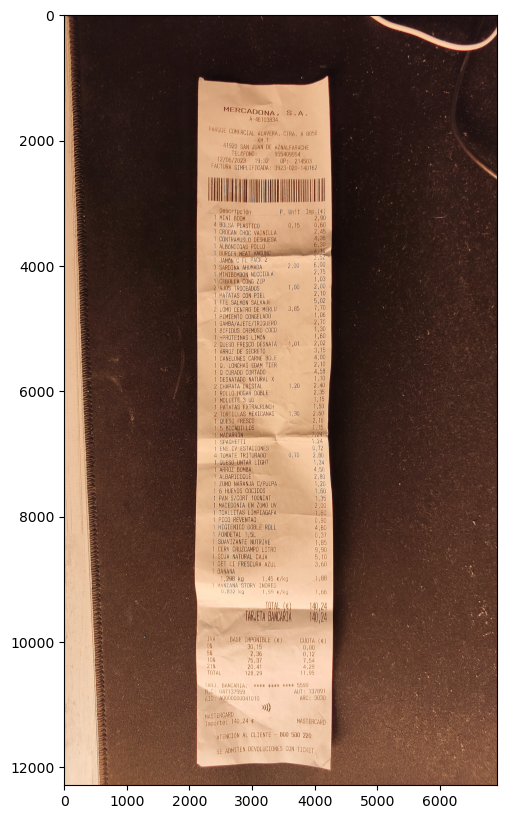

In [4]:
file_name = "mercadona-03.jpg"
image = cv2.imread(file_name) 
original = image.copy()
resize_ratio = 3
image = opencv_resize(image, resize_ratio)
#image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
plot_img(image)

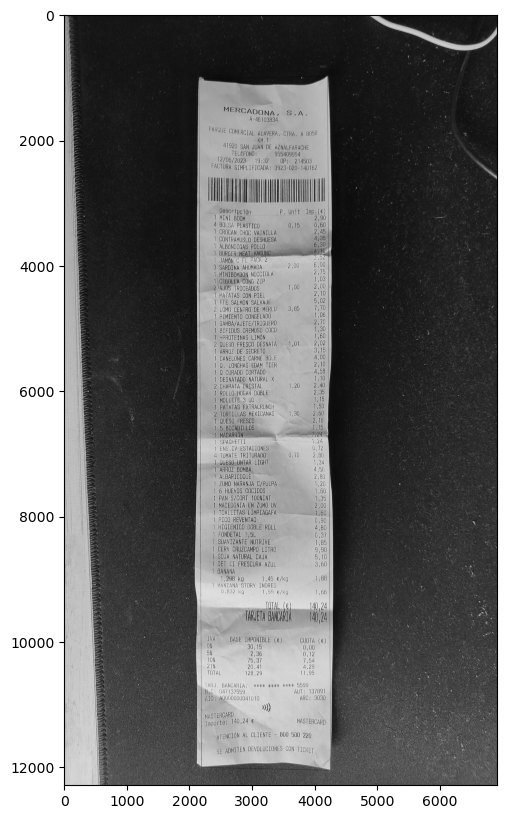

In [5]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#blurred = cv2.GaussianBlur(gray, (5, 5), 1)
#rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
#dilated = cv2.dilate(blurred, rectKernel)
#edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
ret, thresh = cv2.threshold(gray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 5)

# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)

# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

get_receipt_contour(largest_contours)

receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(gray, [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [6]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
scanned = opencv_resize(scanned, 3)

In [7]:
def primary_transf(rgba, roundup=127, rounddown=127):
    width, height, channels = rgba.shape
    primary = rgba*1
    primary[np.greater_equal(primary, roundup)] = 255
    primary[np.less(primary, rounddown)] = 0
    return primary

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image, 15)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

#blurred
def blurred(img):
    return bilateralFilter(img, 1, 10, 120)

#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 2)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

def resize(image):
    return opencv_resize(image, 2)
    

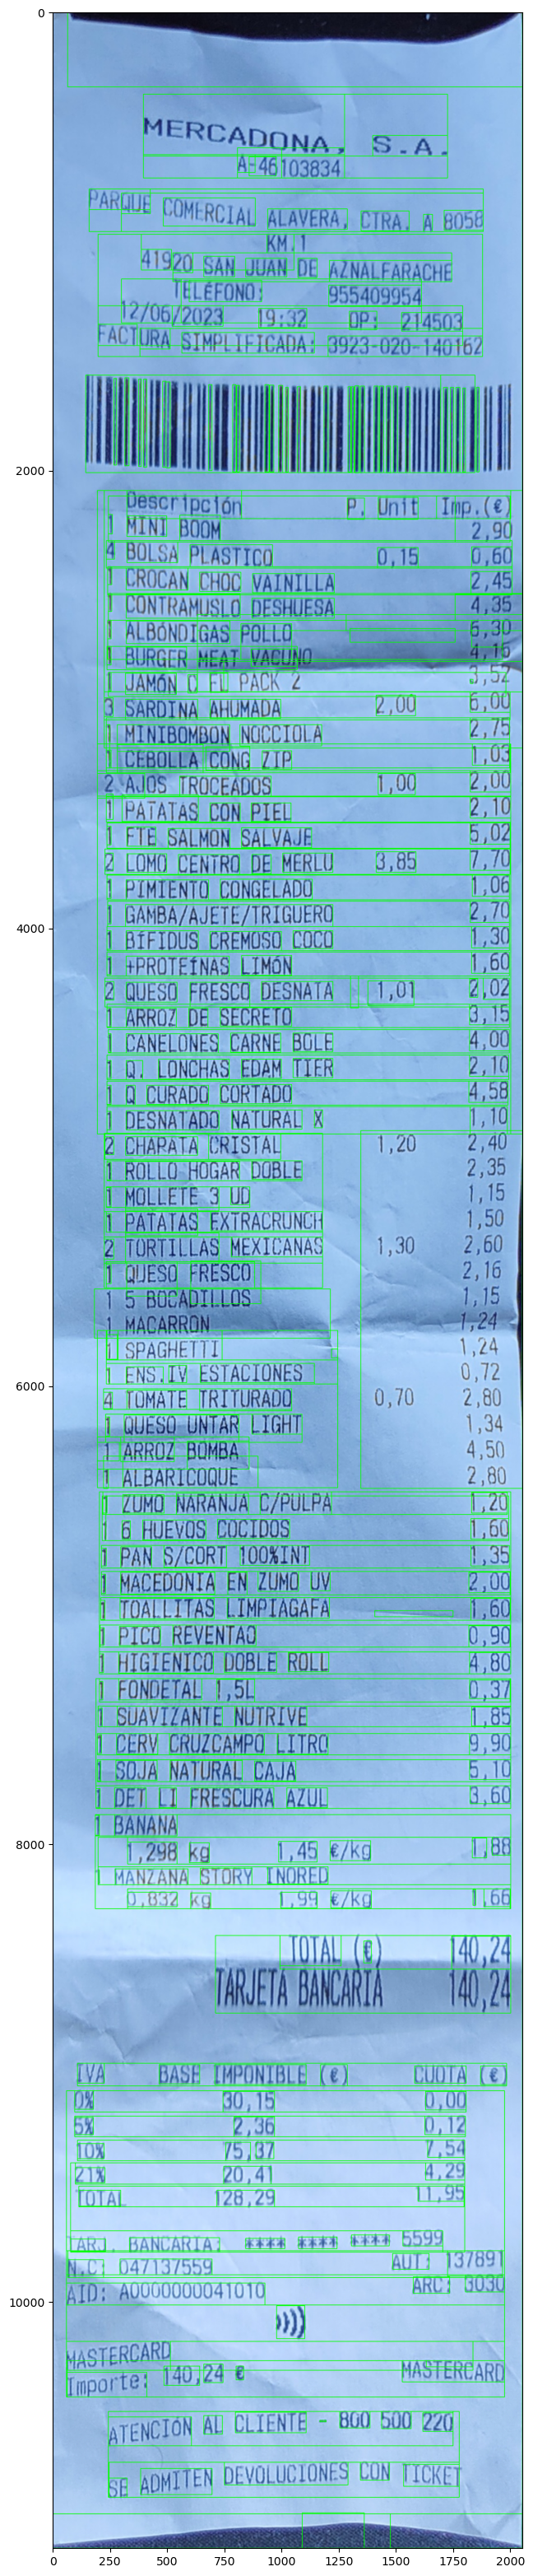

In [8]:
d = pytesseract.image_to_data(scanned, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(scanned.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_big(boxes)

In [9]:
print(pytesseract.image_to_string(scanned, lang='eng', config='--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNÑOPQRSTUVWXYZ,\ '))

ST,
ERCADONA, SA
A46 103834
PARGIE
NUUE COMERCIAL ALAVERA, CTRA, A 8056
41920 SAN QUANT
20 SAN JUAN DE AZNALFARACHE
338 TELEFONO 955409954
FACT 62023 1932 OP 214503
JRA SIMPLIFICADA 3923020 140162
DES P, U I,
1 MINT BOOM FM
4 BOLSA PLASTICO 0,15 0,60
1 CROCAN CHOG VAINILLA 2,45
1 CONTRAMUSLO DESHUESA 4585
1 ALBONDIGAS POLLO
BURGER MEAT VACUO 1,16
1 JAMON CG FL PACK 2
3 SARDINA AHUMADA 2 ,0U 6 , 00
 MINTBOMBON NOCCIOLA 2,19
NM ZIP ,03
2 ANOS TROCEADOS 1,00 2,00
1 PATATAS CON PIEL 2,10
1 FTE SALMON SALVAJE 5 02
2 LOMO CENTRO DE MERLU 3,85 TE IK
1 PIMIENTO CONGELADO ,06
 GAMBAAJETETRIGUERO 2,10
1 BIFIDUS CREMOSO COCO 1,30
1 PROTELNAS LIMON 1,60
2 QUESO FRESCO DESNATA 1,01 Z,02
1 ARROZ DE SECRETO
1 CANELONES CARNE BOLE 4,00
1 Q, LONCHAS EDAM TIER 2,10
1 Q CURADG CORTADO 4,58
 DESNATADO NATURAL X 1,10
2 CHARATA CRISTAL 1,20 2,40
1 ROLLO HOGAR DOBLE 2,39
1 MOLLETE 3 UD 1,15
1 PATATAS EXTRACRUNCH 1,50
2 TORTILLAS MEXICANAS MO ,A
1 QUESO FRESCO , A
5 BOCADILLOS
4
1 SPAGHETTI 1,24
1 ENS,IV ESTA

In [10]:
def calculate(image):
    text = pytesseract.image_to_string(image, lang='eng', config='--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNÑOPQRSTUVWXYZ,\ ')
    # extract lines
    regex = "^([0-9]+){1}(\ [a-zA-Z]+[A-Za-z0-9\ ,\.]+\ +){1}([0-9]*([,][0-9]*)+){1,2}"
    lines = text.splitlines()
    valid = 0
    total = 0.00
    for l in lines:
        m = re.search(regex, l)
        if m is not None:
            line = m.group()
            print(line)
            quantity = re.search("[0-9]*", line).group()
            line = line.replace(quantity, "", 1)
            if int(quantity) > 1:
                quantity = int(quantity)
                split = re.split("([0-9]*,+[0-9]+)", line)
                price = split[len(split)-2]
                line = line.replace(price, "")
                try:
                    price = float(price.replace(",","."))
                    total += price
                    priceUnit = price/quantity
                    #print("Precio total: ", price)
                    #print("Precio unitario: ", priceUnit)
                    split = re.split("([0-9]*,+[0-9]+)", line)
                    if len(split)>1:
                        price = split[len(split)-2]
                        line = line.replace(price, "")
                    #print("Artículo: ", line)
                    valid+=1
                except:
                  print("Error ", price, "cannot be casted to float")
            else: 
                line.replace("/n","")
                split = re.split("([0-9]*,+[0-9]+)", line)
                price = split[len(split)-2]
                try:
                    total += float(price.replace(",","."))
                    #print("Artículo: ", line.replace(price, ""))
                    #print("Precio: ", price)
                    valid+=1
                except:
                  print("Error ", price, "cannot be casted to float")
    return {'Total': round(total,2),
           'Accourance': round((total*100)/140.24, 2),
           'lines': len(lines),
           'validLines': valid}
    #return Tou round(total,2), 
    #        round((total*100)/140.24, 2)

In [11]:
import sys

def apply_actions(fns, img):
    try:
        for fn in fns:
            img = fn(img)
        fun = print_names(fns)
        total, percent = calculate(img)
        return fun, total, percent
    except:
        print("ERROR")

def print_names(fns):
    res = ""
    for fn in fns:
        if res != "":
            res += " - "
        res += fn.__name__
    return res

img = scanned.copy()
img = get_grayscale(img)
#img = thresholding(img)
#img = resize(img)
#img = primary_transf(img)
img = erode(img)
print(calculate(img))

4 BOLSA PLASTICO 0,15 0,60
1 CROCAN CHOC VAINILLA 2,45
1 CONTRAMUSLO DESHUESA 4,35
1 ALBONDIGAS POLLO 6,30
3 SARDINA AHUMADA 2,00 6,00
1 MINIBOMBON NOCCIOLA 2,15
1 CEBOLLA CONG ZIP 1,03
1 PATATAS CON PIEL 2,10
1 FTE SALMON SALVAJE 5,02
2 LOMO CENTRO DE MERLU 3,85 7,70
1 PIMIENTO CONGELADO 1,06
1 GAMBAJAJETETRIGUERO 2,70
1 BIFIDUS CREMOSO COCO 1,30
1 PROTELNAS LIMON 1,60
2 QUESO FRESCO DESNATA 1,,01 2,02
1 ARROZ DE SECRETO ,15
1 CANELONES CARNE BOLE 4,00
1 Q, LONCHAS EDAM TIER 2,10
1 Q CURADO CORTADO 4,58
1 DESNATADO NATURAL X 1,10
2 CHAPATA CRISTAL 1,20 2,40
1 ROLLO HOGAR DOBLE 2,0
1 MOLLETE 3 UD 1,15
1 PATATAS EXTRACRUNCH 1,50
2 TORTILLAS MEXICANAS 1,30 2,60
1 QUESO FRESCO 2,16
1 SPAGHETTI 1,24
1 ENS,IV ESTACIONES 0,72
4 TOMATE TRITURADO 0,70 2,80
1 ARROZ BOMBA 4,50
1 ALBARICOQUE 2,80
1 ZUMO NARANJA CPULPA 1,20
1 PAN SCORT 100KINT 1,35
1 MACEDONIA EN ZUMO UV 2,00
1 PICO REVENTAO 0,90
1 HIGIENTCO DOBLE ROLL 4,80
1 SUAVIZANTE NUTRIVE 1,85
1 CERV CRUZCAMPO LITRO 9,90
1 SOJA NATURAL CAJA 

actions = [all, primary_transf, blurred, get_grayscale, remove_noise, thresholding, dilate, erode, opening, canny, resize]
#actions = [primary_transf, get_grayscale, thresholding, remove_noise, resize]
image_base = scanned.copy()
levels = 2
res = list()
for a in range(len(actions)):
    fnsa = [actions[a]]
    res.append(apply_actions(fnsa, image_base.copy()))
    if levels > 1:
        for b in range(len(actions)):
            fnsb = list(fnsa)
            if actions[b] not in fnsb:
                fnsb.append(actions[b])
                res.append(apply_actions(fnsb, image_base.copy()))
                if levels > 2:
                    for c in range(len(actions)):
                        fnsc = list(fnsb)
                        if actions[c] not in fnsc:
                            fnsc.append(actions[c])
                            apply_actions(fnsc, scanned)
                            for d in range(len(actions)):
                                fnsd = list(fnsc)
                                if actions[d] not in fnsd:
                                    fnsd.append(actions[d])
                                    apply_actions(fnsd, scanned)
                                    for e in range(len(actions)):
                                        fnse = list(fnsd)
                                        if actions[e] not in fnse:
                                            fnse.append(actions[e])
                                            apply_actions(fnse, scanned)
                                            for f in range(len(actions)):
                                                fnsf = list(fnse)
                                                if actions[f] not in fnsf:
                                                    fnsf.append(actions[f])
                                                    apply_actions(fnsf, scanned)


In [12]:
for r in res:
    if r != None:
        print(r)

NameError: name 'res' is not defined